


# 들어가며

오늘은 시계열 예측을 다루는 여러 통계적 기법 중에 가장 널리 알려진 ARIMA(Auto-regressive Integrated Moving Average)에 대해 알아보고 이를 토대로 특정 주식 종목의 가격을 예측해보는 실습을 진행해보자. ARIMA는 탄탄한 통계학 이론적 기반을 갖추고 있으며, 시계열 데이터를 이해하는 관점을 훈련하는 데에도 도움이 된다는 점에서 한 번쯤 다뤄볼 만한 주제일 것이다.

**학습 목표**
- 시계열 데이터의 특성과 안정적(Stationary) 시계열의 개념을 이해한다.
- ARIMA 모델을 구성하는 AR, MA, Diffencing의 개념을 이해하고 간단한 시계열 데이터에 적용해 본다.
- 실제 주식 데이터에 ARIMA를 적용해서 예측 정확도를 확인해 본다.

**목차**

- 시계열 예측이란
  - 미래를 예측한다는 것은 가능할까?
  - Stationary한 시계열 데이터란?
  - 시계열 데이터 사례 분석
  - Stationary 여부를 체크하는 통계적 방법
- ARIMA 시계열 예측
  - 시계열 예측의 기본 아이디어 : Stationary하게 만들 방법은 없을까?
  - ARIMA 모델의 개념
  - ARIMA 모델 훈련과 추론
- 프로젝트 : 주식 예측에 도전해 보자



# 1. 시계열 예측이란

## (1) 미래 예측은 가능한 것인가

시계열이란 **시간 순서대로 발생한 데이터의 수열**이라는 뜻이다.

![](https://images.velog.io/images/och9854/post/f0b18b52-d356-42bb-aee8-5a3047d51a1a/image.png)



간단한 수식으로 표현하면 다음과 같다.

주가 예측을 위해서 **두 가지**의 전제가 필요하다.
>1. 과거 데이터에 일정한 패턴이 발견된다.   
>2. 과거 패턴은 미래에도 동일하게 반복된다.

위 두 가지를 한 문장으로 줄이면 다음과 같다.
> `안정적(stationary)` 데이터에 대해서만 미래 예측이 가능하다.

안정적이라는 것은 **시계열 데이터의 통계적 특성이 변하지 않는다**는 뜻이다.

ARIMA 모형은 stationarity를 가정하므로, 전처리를 통해서 stationary time series로 변환해 준 이후에 ARIMA 모형을 적용할 수 있다.

> 📖 꼭 보고 오기: [White Noise Process vs Random Walk Process vs Stationary Process](https://rfriend.tistory.com/691)

[그림자로 원유재고 알아낸다](https://news.einfomax.co.kr/news/articleView.html?idxno=4082410)

시계열 분석은 완벽한 미래를 보장해주지 않는다.($\because$ 예측하지 못한 외부적 변수에 의해 시계열 데이터 분석의 전제가 되는 안정성이 훼손될 여지가 있음)

## (2) Stationary한 시계열 데이터

현실적으로 다루는 시계열 데이터는 직관적인 안정성의 정의를 만족하는 정도면 충분히 ARIMA 등의 시계열 모델을 통해 분석을 할 수 있다.

아래 링크 글에서 `1. Basic- Time Series Modeling`파트를 읽어보자.

- [A  Complete Tutorial on Time Series Modeling in R](https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/)

**평균, 분산, 자기공분산** 이 세 가지가 안정적인 시계열에서 시간의 추이와 관계없이 일정해야 한다.

[Covariance와 Correlation](https://destrudo.tistory.com/15)

[Autocovariance와 Autocorrelation](https://m.blog.naver.com/sw4r/221030974616)

이제 안정적 시계열이 가져야 할 요건으로 다시 돌아와보자. 다음의 예시를 보자.

> 예시) 직전 5년 치 판매량 X(t-4), X(t-3), X(t-2), X(t-1), X(t)를 가지고 X(t+1)이 얼마일지 예측해보자.

이 예측이 의미가 있으려면 
- **t에 무관하게** 예측이 맞아야 한다. 
- 그러려면 **t에 무관하게**  X(t-4), X(t-3), X(t-2), X(t-1), X(t)의 `평균`과 `분산`이 `일정 범위` 안에 있어야 한다. 
- 또한 **h에 대해서만 달라지는 일정한 상관도**를 가져야 한다.





## (3) 시계열 데이터 사례분석

```
$ mkdir -p ~/aiffel/stock_prediction/data
$ ln -s ~/data/* ~/aiffel/stock_prediction/data
```

### 1) 시계열 데이터(Time Series) 생성
온도변화를 다루는 `Daily Minimum Temperatures in Melbourne` 데이터를 다뤄보자.



```python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

print('슝=3')
```

    슝=3



```python
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/daily-min-temperatures.csv' 
df = pd.read_csv(dataset_filepath) 
print(type(df))
df.head()
```

    <class 'pandas.core.frame.DataFrame'>





<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }
    
    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Date</th>
      <th>Temp</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>1981-01-01</td>
      <td>20.7</td>
    </tr>
    <tr>
      <th>1</th>
      <td>1981-01-02</td>
      <td>17.9</td>
    </tr>
    <tr>
      <th>2</th>
      <td>1981-01-03</td>
      <td>18.8</td>
    </tr>
    <tr>
      <th>3</th>
      <td>1981-01-04</td>
      <td>14.6</td>
    </tr>
    <tr>
      <th>4</th>
      <td>1981-01-05</td>
      <td>15.8</td>
    </tr>
  </tbody>
</table>
</div>



Pandas에서 Series라는 자료구조를 제공한다. 오늘 다루게 될 시계열도 결국 시간 컬럼을 index로 하는 Series로 표현된다.

읽어들인 데이터 파일은 Pandas를 통해 2캐의 컬럼을 가진 DataFrame으로 변환되었다. 이것은 아직 시계열의 데이터 구조는 아니다.

위의 DataFrame에서 Date 컬럼을 index로 삼아 시계열을 생성해보자.


```python
# 이번에는 Date를 index_col로 지정해 주었습니다. 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df))
df.head()
```

    <class 'pandas.core.frame.DataFrame'>




<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }
    
    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Temp</th>
    </tr>
    <tr>
      <th>Date</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>1981-01-01</th>
      <td>20.7</td>
    </tr>
    <tr>
      <th>1981-01-02</th>
      <td>17.9</td>
    </tr>
    <tr>
      <th>1981-01-03</th>
      <td>18.8</td>
    </tr>
    <tr>
      <th>1981-01-04</th>
      <td>14.6</td>
    </tr>
    <tr>
      <th>1981-01-05</th>
      <td>15.8</td>
    </tr>
  </tbody>
</table>
</div>



시간 컬럼이 index가 되었지만 아직 type은 DataFrame으로 나온다. 우리가 찾는 시계열은 아래에 있다.


```python
ts1 = df['Temp']  # 우선은 데이터 확인용이니 time series 의 이니셜을 따서 'ts'라고 이름 붙여줍시다!
print(type(ts1))
ts1.head()
```

    <class 'pandas.core.series.Series'>





    Date
    1981-01-01    20.7
    1981-01-02    17.9
    1981-01-03    18.8
    1981-01-04    14.6
    1981-01-05    15.8
    Name: Temp, dtype: float64



`df['Temp']`는 index 구조가 동일하므로 Numpy, Pandas, Matplolib 등 여러 라이브러리들이 호환해서 지원해준다. 하지만 그러지 않은 경우도 간혹 발생하므로 여기서는 명확하게 Serise 객체를 가지고 진행하자.

### 2) 시계열 안정성의 정성적 분석

이제 시각화를 통해 Stationarity 여부를 확인해보자.

> 📖 꼭 볼것 [Checking the Stationarity](https://rfriend.tistory.com/694)


```python
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts1)
```




    [<matplotlib.lines.Line2D at 0x7f23f54ffdc0>]




​    
![](https://images.velog.io/images/och9854/post/6fde169c-dcd6-4d26-849a-9c7edc96ab33/output_10_1.png)


```python
ts1[ts1.isna()]  # 시계열(Time Series)에서 결측치가 있는 부분만 Series로 출력합니다.
```




    Series([], Name: Temp, dtype: float64)



다행히 결측치는 없다. NaN이 있는 데이터는 통계분석 시 많은 오류를 일으킬뿐더러 분석 결과에도 악영향을 미칠 것이다.

만약 결측치가 있다면, 두 가지 방법으로 결측치를 처리할 수 있다.
> 1. 결측치 데이터를 모두 삭제(drop)
> 2. 결측치 주변 값들을 이용해 interpolate 해서 대입

Pandas에서 결측치 보간을 처리하는 메서드는 다음과 같으며, 상세한 설명은 [여기](https://rfriend.tistory.com/264)를 참고하자.


```python
# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다. 
ts1=ts1.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무를 다시 확인합니다.
print(ts1[ts1.isna()])

# 다시 그래프를 확인해봅시다!
plt.plot(ts1)
```

    Series([], Name: Temp, dtype: float64)





    [<matplotlib.lines.Line2D at 0x7f23cb168a60>]



![](https://images.velog.io/images/och9854/post/dbb3eb9e-7182-496e-8a50-3298c33f9991/output_13_2.png)


시계열 데이터의 통계적 특성(평균, 분산, 자기공분산)을 좀 더 명료하게 시각화해보자.

아래는 일정 시간 내 `구간 통계치(Rolling Statistic)`를 시각화하는 함수이다.

`현재 타임 스텝` ~ `window에 주어진 타입 스텝 이전`의   
1. 구간의 평균(rolling mean, 이동평균)   
2. 표준편차(rolling std, 이동표준편차)   
를 원본 시계열과 함께 **시각화**해 보면 좀 더 뚜렷한 경향성을 확인할 수 있다.

[Rolling mean](https://www.econowide.com/3544)


```python
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')
```

    슝=3



```python
plot_rolling_statistics(ts1, window=12)
```


![](https://images.velog.io/images/och9854/post/061f183e-bb23-4dd0-bfce-989df3076bbb/output_16_0.png)

시각화 결과만 놓고서 시계열 데이터가 안정적이라고 명확하게 결론을 내릴 수 없다! **좀 더 통계적인 접근을 다음 스텝에서 다루고, 이번에는 다른 시계열 데이터 패턴과 비교해보자.**

### 3) 다른 데이터에 대해서도 비교해 보자.

International airline passengers 데이터셋이다. 월별 항공 승객 수(천명 단위)의 시계열 데이터인데 기온 변화 데이터셋과는 좀 다른 패턴이 나타나지 않을까?


```python
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/airline-passengers.csv' 
df = pd.read_csv(dataset_filepath, index_col='Month', parse_dates=True).fillna(0)  
print(type(df))
df.head()
```

    <class 'pandas.core.frame.DataFrame'>




<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }
    
    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Passengers</th>
    </tr>
    <tr>
      <th>Month</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>1949-01-01</th>
      <td>112</td>
    </tr>
    <tr>
      <th>1949-02-01</th>
      <td>118</td>
    </tr>
    <tr>
      <th>1949-03-01</th>
      <td>132</td>
    </tr>
    <tr>
      <th>1949-04-01</th>
      <td>129</td>
    </tr>
    <tr>
      <th>1949-05-01</th>
      <td>121</td>
    </tr>
  </tbody>
</table>
</div>




```python
ts2 = df['Passengers']
plt.plot(ts2)
```




    [<matplotlib.lines.Line2D at 0x7f23f534c490>]



![](https://images.velog.io/images/och9854/post/d39f5dbc-038e-4bfd-af7a-a6c0d15c3a5f/output_20_1.png)


이전 데이터셋과 달리, 시간의 추이에 따라 시계열 평균과 분산이 커지는 패턴이 보인다.

rolling statistics를 추가해서 시각화해보자.


```python
plot_rolling_statistics(ts2, window=12)
```

![](https://images.velog.io/images/och9854/post/e767b724-caa0-4a57-b405-bba8ab18bb0c/output_22_0.png)


이후 스텝에서는 `Non-stationary sequential data에 대한 시계열 분석 기법` 다뤄보자.

## (4) Stationary 여부를 체크하는 통계적 방법

### 1) Augmented Dickey-Fuller Test

이번 스텝에서는 **Augmented Dickey-Fuller Test(ADF Test)**라는 시계열 데이터의 stationary를 테스트하는 통계적 방법을 소개하려고 한다.

이 테스트는   
> 1. `주어진 시계열 데이터가 안정적이지 않다`라는 `귀무가설(Null Hypothesis)`를 세운 후   
> 2. 통계적 가설 검정을 통해 귀무가설이 기각될 경우   
> 3. `이 시계열 데이터가 안정적이다`라는 `대립가설(Alternative Hypothesis)`을 채택한다.   
는 내용이다.

> ❓ 귀무가설, 대립가설, p-value 이란?(AIFFEL에 의해 작성됨)

> 우리가 일반적으로 생각하는 가설은 아마 다음과 같을 수 있습니다. “지구는 둥글 것이다." 또는 “태양이 지구를 돌 것이다.” 하지만 통계적 가설 검정은 어떠한 큰 이론을 제안하는 가설이 아닙니다. 통계에서 가설은 우리가 알고 싶어 하는 “어떤 모집단의 모수(예: 평균, 분산, 등)에 대한 잠정적인 주장"입니다. 따라서 통계적 가설은 앞서 예를 든 가설들과는 다르게 일정한 형식을 따라야 합니다.

> 그 형식이 바로 “ 귀무가설( Null hypothesis:H0)” 과 “ 대립가설( Alternative hypothesis:H1)” 입니다. 통계적 가설 검정을 하려면 우선 두 가지 형식적 가설 (귀무가설 과 대립가설)을 설정해야 합니다. 그리고 어떤 가설을 채택을 할지를 확률적으로 따져보고 둘 중 하나를 채택합니다. 그러면 귀무가설은 무엇이고 대립가설은 무엇일까요?

> 귀무 가설은 통계학에서 처음부터 버릴 것을 예상하는 가설이다. 차이가 없거나 의미있는 차이가 없는 경우의 가설이며 이것이 맞거나 맞지 않다는 통계학적 증거를 통해 증명하려는 가설입니다. 쉽게 말하면 “모집단의 모수는 00와 같다.” 또는 “ 모집단의 모수는 00와 차이가 없다.” 라고 가정하는 것을 말합니다. 예를 들면 1) 만약 전국 남학생의 평균 키가 170cm라는 주장을 통계적으로 검정한다면, 이에 대한 귀무 가설은 “전국 남학생의 평균 키는 170cm과 같다.(또는 차이가 없다.)”가 될 것입니다. 2)제약 회사에서 개발한 백신의 효과를 검정한다면, 귀무가설은 “개발한 백신은 효과가 없다.(또는 차이가 없다).” 가 됩니다. 즉 귀무가설은 “~와 차이가 없다.” “~의 효과가 없다.” “~와 같다.” 라는 형식으로 설정된다는 것을 알 수 있습니다.

> 대립가설의 정의는 “귀무가설이 거짓이라면 대안적으로 참이 되는 가설" 입니다. 쉽게 설명하면 “귀무가설이 틀렸다고 판단했을 때(기각되었을 때), 대안적으로 선택하는(채택되는) 가설"을 말합니다. 다시 예로 설명드리면 대립가설은 “모집단의 모수는 00와 다르다.” 또는 “ 모집단의 모수는 00와 차이가 있다.” 라고 가정하는 것을 말합니다. 예를 들면 1) 만약 전국 남학생의 평균 키가 170cm라는 주장을 통계적으로 검정한다면, 이에 대한 대립 가설은 “전국 남학생의 평균 키는 170cm와 다르다.(또는 차이가 있다.)”가 될 것이고, 2)제약 회사에서 개발한 백신의 효과를 검정한다면, 대립가설은 “개발한 백신은 효과가 있다.(또는 차이가 있다).” 가 됩니다. 즉 대립가설은 “ ~ 와 차이가 있다.” “ ~ 의 효과는 있다.” “ ~ 와 다르다.” 라는 형식으로 설정된다는 것을 알 수 있습니다.

> p-value 정의는 “귀무가설이 참이라고 가정했을 때, 표본으로 얻어지는 통계치(예: 표본 평균)가 나타날 확률" 입니다. p값이 낮다는 것은 귀무가설이 참이라는 가정 하에서 표본을 추출했을 때, 이런 표본 평균이 관측될 확률이 낮다는 것을 뜻합니다. 즉 p 값이 매우 낮으면, 이러한 표본 통계량은 우연히 나타나기 어려운 케이스이기 때문에, 우리는 귀무가설을 채택하지 않고(기각하고), 대안적인 가설, 즉 대립가설을 채택하게 됩니다

이제 ADF Test의 세부 알고리즘을 보고, `statsmodels` 패키지에서 제공하는 `adfuller` 메서드를 이용해 ADF Test의 결과를 이용하자.

> ❔ What is a Unit Root test? Why is unit root a problem?   
> ❕ Unit root tests are tests for stationarity in a time series. A time series has stationarity if a shift in time doesn’t cause a change in the shape of the distribution; unit roots are one cause for non-stationarity.

ADF 검정은 시계열 데이터가 stationary인지를 테스트하기 위한 단위근 검정 방법이다. 단위근(unit root)이란 $x=1, y=1$인 해로, 시계열 자료에서 예측할 수 없는 결과를 가져온다.

검정에는 자료에 단위근이 존재한다는 귀무가설($H_0 : \alpha = 1$)과 자료에 단위근이 존재하지 않아 시계열 자료가 stationary를 만족한다는 대립가설($H_1 : \alpha \neq 1$), 이렇게 2가지 가설을 사용하고, 검정을 통해 귀무가설을 기각하면 stationary 하다고 볼 수 있다.

ADF 검정은 DF 검정을 일반화한 검정이다. DF 단위근 검정은 단위근이 존재한다는 귀무가설을 통계적으로 검정하는 방법이다.

![](https://images.velog.io/images/och9854/post/ce35e082-33af-4c51-bf21-ce308b1d7ed1/image.png)

`c`는 `시계열 데이터의 라벨`, `$\beta$`는 `시계의 데이터의 추세항`이다. 각 파라미터를 regression으로 추정해 a가 단위근을 가질 확률을 검정한다. $\alpha$=1 이면 단위근을 가지는 것이기 때문에 정상성을 띄지 않는다.

ADF test는 DF test에 `p lag`의 차분을 추가해 검정 능력을 강화시켰다. 식은 아래와 같다.

![](https://images.velog.io/images/och9854/post/889ecd34-3d2c-42d2-bc23-ae1acc492071/image.png)


식에서 `p lag`의 차분만큼 항이 추가된 것을 알 수 있다. t-p 시점까지의 차분 경향성을 파악할 수 있어서 주기를 가진 데이터의 stationarity 여부를 판단할 수 있다.

> ❔ 차분이란? 차분경향성이란? [정상성과 차분](https://otexts.com/fppkr/stationarity.html)         

> ❕ Differencing이란 연이은 관측값들의 차이를 계산하는 것이다. 이는 시계열의 수준에서 나타나는 변화를 제거하여 시계열의 평균 변화를 일정하게 만드는 데 도움을 주어 결과적으로 추세, 계절성을 감소(제거) 시켜준다.   
> 식으로 나타내면 다음과 같다. $y'_t$는 T-1개의 값을 가진 것이다.  
>
> > $y′_t=y_t−y_t−1$

> ❕ 가끔 차분을 구한 데이터가 stationarity가 없어 보일 수 있다. stationarity를 지니는 시계열을 얻기 위해서 데이터에서 한 번 더 차분을 구하는 작업이 필요할 수도 있다. 이 경우 $y''_t$는 T-2개의 값을 가진 것이다. 이러면 원본 데이터의 "변화에서 일어나는 변화"를 모델링하는 셈이다. (실제 상황에서는 2차 차분 이상으로 구하는 경우는 거의 없다.)
>
> > $y′′_t = y′_t − y'_t−1 = (y_t − y_t−1)−(y_t−1−y_t−2)= y_t−2_yt−1+y_t−2$

ADF 검정의 귀무가설은 DF 검정과 귀무가설이 같으므로, **검정통계량이 Critical Value보다 작거나 p-value가 설정한 유의수준 값보다 작으면 stationary한** 시계열 데이터라고 볼 수 있다.

- Test statistic 참고 자료
   - [test statistic: for deciding to support or reject the null hypothesis](https://www.statisticshowto.com/test-statistic/)
   - [검정통계량(what is a test statistic)](https://www.scribbr.com/statistics/test-statistic/)


- p-value 정의: 귀무가설을 가정했을 때의 확률분포 상에서 현재 관측보다 더 극단적인 관측이 나올 확률. 귀무가설의 가정이 틀렸다고 볼 수 있는 확률이기도 함. 0.05 미만으로 값이 나온다면 귀무가설을 기각하고 대립가설을 채택할 수 있는 근거가 된다.

[유의확률-위키백과](https://ko.wikipedia.org/wiki/%EC%9C%A0%EC%9D%98_%ED%99%95%EB%A5%A0)

[가설,검정,p-value](https://yeomko.tistory.com/37)

[추가: 세부 알고리즘: Unit Root Test 개념으로부터 ADF Test에 대한 설명](https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/)

###  2) statsmodels 패키지와 adfuller 메서드

statsmodels 패키지는 R에서 제공하는 통계검정, 시계열분석 등의 기능을 파이썬에서도 이용할 수 있도록 하는 강력한 통계 패키지이다. 이번 노드에서는 statsmodels 패키지의 기능을 주로 활용할 것이다.

**`adfuller` 메서드를 이용해 _주어진 timeseries에 대한 ADF Test**를 수행하자.

[What is adfuller method?](https://www.hackdeploy.com/augmented-dickey-fuller-test-in-python/)


```python
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')
```

    슝=3



```python
# 이전 스텝에서 정상적으로 분석해 보았던 두 시계열에 대한 Augmented Dickey-Fuller Test를 수행

augmented_dickey_fuller_test(ts1)
```

    Results of Dickey-Fuller Test:
    Test Statistic                   -4.444805
    p-value                           0.000247
    #Lags Used                       20.000000
    Number of Observations Used    3629.000000
    Critical Value (1%)              -3.432153
    Critical Value (5%)              -2.862337
    Critical Value (10%)             -2.567194
    dtype: float64


`ts1 시계열이 안정적이지 않다는 귀무가설`은 p-value가 거의 0에 가깝게 나타났다.

따라서 이 귀무가설은 기각되고, `이 시계열은 안정적 시계열`이라는 대립가설이 채택된다.


```python
augmented_dickey_fuller_test(ts2)
```

    Results of Dickey-Fuller Test:
    Test Statistic                   0.815369
    p-value                          0.991880
    #Lags Used                      13.000000
    Number of Observations Used    130.000000
    Critical Value (1%)             -3.481682
    Critical Value (5%)             -2.884042
    Critical Value (10%)            -2.578770
    dtype: float64


`ts2 시계열이 안정적이지 않다는 귀무가설`은 p-value가 거의 1에 가깝게 나타났다.

p-value가 1에 가깝다는 것이 이 귀무가설(주어진 시계열 데이터가 안정적이지 않다.) 이 옳다는 직접적인 증거는 아니다. 하지만 **이 귀무가설을 기각할 수는 없게** 되었으므로 `이 시계열이 안정적인 시계열`이라고 말할 수는 없다!

[$\alpha - error, \beta - error$](https://angeloyeo.github.io/2021/01/26/types_of_errors.html)

# 2. 시계열 예측의 기본 아이디어: Make it Stationary

Non-stationary한 시계열을 stationary한 시계열로 바꾸려면 어떻게 해야 할까?   
1. 정성적 분석을 통해 보다 stationary한 특성을 갖도록 **기존 시계열 데이터를 가공/변형**   
2. **시계열 분해(Time series decompostion) ** 기법을 적용

## (1) 보다 Stationary한 시계열로 가공해 가기

### 1) 로그함수 변환

데이터가 시간 추이에 따라 분산이 점점 커지고 있다. 시계열이 이런 특성을 보일 경우에는 로그함수로 변환을 하는 것이 도움이 된다.

> ❔ Why do we use log in statistic? [link](https://www.forbes.com/sites/naomirobbins/2012/01/19/when-should-i-use-logarithmic-scales-in-my-charts-and-graphs/)   
> ❕ There are two main reasons to use logarithmic scales in charts and graphs. The first is to respond to skewness towards large values; i.e., cases in which one or a few points are much larger than the bulk of the data. The second is to show percent change or multiplicative factors.



```python
ts_log = np.log(ts2)
plt.plot(ts_log)
```




    [<matplotlib.lines.Line2D at 0x7f23d192f2b0>]


![](https://images.velog.io/images/och9854/post/b291605b-497d-4b2d-9ab8-b7b39c714da4/output_30_1.png)  



```python
# log transformation의 효과를 확인하기 위해 ADF Test 수행
augmented_dickey_fuller_test(ts_log)
```

    Results of Dickey-Fuller Test:
    Test Statistic                  -1.717017
    p-value                          0.422367
    #Lags Used                      13.000000
    Number of Observations Used    130.000000
    Critical Value (1%)             -3.481682
    Critical Value (5%)             -2.884042
    Critical Value (10%)            -2.578770
    dtype: float64


0.42로 절반 이상 줄었다. 하지만 남은 문제점은 **시간 추이에 따라 평균이 계속 증가한다는 점이다.**

### 2) Moving Average 제거 - 추세(Trend) 상쇄하기

- trend(추세): 시계열 분석에서 위와 같이 시간 추이에 따라 나타나는 평균값 변화

이 변화량을 제거하려면 거꾸로 Moving Average, 즉 rolling mean을 구해서 ts_log에서 빼줘야 한다.


```python
moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')
```




    [<matplotlib.lines.Line2D at 0x7f23d18cc6a0>]




![](https://images.velog.io/images/och9854/post/c4b81995-7cd4-4335-87cd-c3149723b46c/output_33_1.png)



```python
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(15)
```




    Month
    1949-01-01         NaN
    1949-02-01         NaN
    1949-03-01         NaN
    1949-04-01         NaN
    1949-05-01         NaN
    1949-06-01         NaN
    1949-07-01         NaN
    1949-08-01         NaN
    1949-09-01         NaN
    1949-10-01         NaN
    1949-11-01         NaN
    1949-12-01   -0.065494
    1950-01-01   -0.093449
    1950-02-01   -0.007566
    1950-03-01    0.099416
    Name: Passengers, dtype: float64



Moving Average 계산 시 앞부분의 경우 Moving Average가 계산되지 않아 NaN이 발생한다. 이들을 제거해주자.


```python
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)
```




    Month
    1949-12-01   -0.065494
    1950-01-01   -0.093449
    1950-02-01   -0.007566
    1950-03-01    0.099416
    1950-04-01    0.052142
    1950-05-01   -0.027529
    1950-06-01    0.139881
    1950-07-01    0.260184
    1950-08-01    0.248635
    1950-09-01    0.162937
    1950-10-01   -0.018578
    1950-11-01   -0.180379
    1950-12-01    0.010818
    1951-01-01    0.026593
    1951-02-01    0.045965
    Name: Passengers, dtype: float64



이전 스텝 메서드를 활용하여 이들을 정성, 정량적으로 분석해보자.


```python
plot_rolling_statistics(ts_log_moving_avg)
```


​    
![](https://images.velog.io/images/och9854/post/e6ae6e83-cbf1-4ca0-8bd2-4e9435b0a3f4/output_38_0.png)



```python
augmented_dickey_fuller_test(ts_log_moving_avg)
```

    Results of Dickey-Fuller Test:
    Test Statistic                  -3.162908
    p-value                          0.022235
    #Lags Used                      13.000000
    Number of Observations Used    119.000000
    Critical Value (1%)             -3.486535
    Critical Value (5%)             -2.886151
    Critical Value (10%)            -2.579896
    dtype: float64


p-value가 0.02 까지 내려왔다. 95% 이상의 confidence로 이 time series는 stationary하다고 볼 수 있다!

### 3) Differencing - Seasonality 계산하기

Trend에 잡히지 않지만 시계열 데이터 내에 **패턴이 파악되지 않은 주기적 변화**는 예측에 방해가 되는 불안정성 요소이다. 이들은 Moving Average 제거로는 상쇄되지 않는 효과인데, 이들을 Seasonality라고 한다.

[시계열 패턴](https://www.forbes.com/sites/naomirobbins/2012/01/19/when-should-i-use-logarithmic-scales-in-my-charts-and-graphs/)

이런 패턴을 상쇄하기 위한 효과적인 방법에 차분이 있다. 시계열을 한 스텝 앞으로 시프트한 시계열을 원래 시계열에 빼 주는 방법이다. 이렇게 되면 남은 것은 **이번 스텝에서 발생한 변화량을 의미**하게 된다.

시프트한 시계열과 원본 시계열에 대한 그래프를 그려보자.


```python
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')
```




    [<matplotlib.lines.Line2D at 0x7f23d1711a30>]



![](https://images.velog.io/images/och9854/post/d7b1987a-0540-4a41-b7f1-09d59e1b9fab/output_42_1.png)


```python
# 원본 시계열 - 시프트한 시계열

ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)
```




    [<matplotlib.lines.Line2D at 0x7f23d16d3ac0>]


![](https://images.velog.io/images/och9854/post/6b9c8aa7-6c51-42db-8bdb-70d2eb9d8528/output_43_1.png)





```python
# check stationality
plot_rolling_statistics(ts_log_moving_avg_diff)
```

![](https://images.velog.io/images/och9854/post/7e7099b6-a3e3-46a4-8d9b-708d80a651d7/output_44_0.png)




```python
# ADF Test
augmented_dickey_fuller_test(ts_log_moving_avg_diff)
```

    Results of Dickey-Fuller Test:
    Test Statistic                  -3.912981
    p-value                          0.001941
    #Lags Used                      13.000000
    Number of Observations Used    118.000000
    Critical Value (1%)             -3.487022
    Critical Value (5%)             -2.886363
    Critical Value (10%)            -2.580009
    dtype: float64


Trend를 제거한 후 1st order differencing을 적용하여 Seasonality를 다소 상쇄한 결과, p-value가 0.02에서 0.0019로 1/10 정도로 줄었다!

## (2) Time Series decomposition

statsmodels 라이브러리 내에 `seasonal_decompose` 메서드를 통해 trend, seasonality를 직접 분리하자.


```python
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
```


![](https://images.velog.io/images/och9854/post/963db6c1-32da-439d-8129-79bd89923904/output_47_0.png)


`Trend + Seasonailty + Residual = Original`이 성립한다. 이러한 Decomposing은 시계열 데이터를 이해하는 중요한 관점을 제시해준다.

그렇다면 이제 Residual에 대해 stationarity를 check하자.


```python
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)
```



![](https://images.velog.io/images/och9854/post/153e3fa9-353c-453b-85f5-b396671541ed/output_49_0.png)


```python
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)
```

    Results of Dickey-Fuller Test:
    Test Statistic                -6.332387e+00
    p-value                        2.885059e-08
    #Lags Used                     9.000000e+00
    Number of Observations Used    1.220000e+02
    Critical Value (1%)           -3.485122e+00
    Critical Value (5%)           -2.885538e+00
    Critical Value (10%)          -2.579569e+00
    dtype: float64


`Decomposing`을 통해 얻은 `Residual`은 매우 낮은 p-value를 보여준다.

#  3. ARIMA 모델의 개념
## (1) ARIMA 모델의 정의

앞선 시계열 데이터와 ARIMA를 사용하여 시계열 데이터 예측 모델을 만들 수 있다.

ARIMA = AR(AutoRegressive) + I(Integrated) + MA(Moving Average)이다.

### 1) AR

![](https://images.velog.io/images/och9854/post/fb841cd0-fa37-4434-9ef3-2998209b5bba/image.png)






- 과거 값들에 대한 회귀로 미래 값을 예측하는 방법
- $Y_t$ 가 이전 p개의 데이터 $Y_{t-1}, Y_{t-2}, ..., Y_{t-p}$ 의 가중합으로 수렴다고 보는 모델
- $Y_t = ϕ_0 + ϕ_1Y_{t-1} + ϕ_2Y_{t-2} + .... + ϕ_pY_{t-p} + e_t$


- AR은 시계열의 Residual에 해당하는 부분을 모델링한다고 볼 수 있다.
- 가중치의 크기가 1보다 작은 Y_{t-1}, Y_{t-2}, ..., Y_{t-p}의 가중합으로 수렴하는 자기회귀 모델과 안정적 시계열은 통계학적으로 동치이다.
- 주식값이 항상 일정한 균형 수준을 유지할 것이라고 예측하는 관점이 바로 주식 시계열을 AR로 모델링하는 관점이라고 볼 수 있다.

### 2) MA

![](https://images.velog.io/images/och9854/post/487299fd-0e47-46cc-bb40-0d390d10ee1b/image.png)


- MA는 Y_t 가 이전 q개의 예측오차값 $e_{t-1}, e_{t-2}, ..., e_{t-q}$의 가중합으로 수렴한다고 보는 모델이다.
- $Y_t = μ + e_t + θ_1e_{t-1} + θ_2e_{t-2} + .... + θ_qe_{t-q}$

- MA는 시계열의 Trend에 해당하는 부분을 모델링한다고 볼 수 있다.
- 예측오차값 $e_{t-1}$이 0보다 크면 모델 예측보다 관측값이 더 높다는 뜻이므로, 다음 $Y_t$ 예측 시에는 예측치를 올려잡게 된다.
- 주식값이 최근의 증감 패턴을 지속할 것이라고 보는 관점이 MA로 모델링하는 관점이라고 볼 수 있다.

### 3) I(차분 누적, Integration)

- `I`는 $Y_t$이 이전 데이터와 d차 차분의 integration이라고 보는 모델이다.
- `I`는 `Seasonality` 부분을 모델링한다.
- d=1 이라면, $Y_t 는 Y_t-1과 \triangle Y_t-1$의 합으로 본다.

이렇게 ARIMA는 3가지 모델을 한 번에 고려한다.

위 그림에서 보듯 주식값이 떨어졌다는 사실을 알게 되었을 때, 

- 오늘 주식이 오르겠지? 라는 AR형태의 기대와
- 추세가 꺾여서 계속 내려가지 않을까? 라는 MA 형태의 우려가 

동시에 떠오를 것이다.

ARIMA는 두 모델 사이에서 적정 수준을 찾아가는 능력을 보여준다.

## (2) ARIMA 모델의 파라미터 p, q, d

ARIMA의 parameter를 잘 설정해야 한다.
- p: AR(자기회귀 모형)의 시차
- d: 차분 누적(I) 횟수
- q: MA(이동평균 모형)의 시차

일반적으로 `p + q < 2, p * q = 0`인 값을 사용하는데, 이는 p, q 중 하나는 0이라는 뜻이다. 그 이유는 많은 시계열 데이터가 AR이나 MA 중 하나의 경향만 가지기 때문이다.

p, q, d는 어떻게 결정할까?

여러 통계학적 시도들 중 대표적인 것은 `ACF(Autoccorrelation Function)`와 `PACF(Partial Autocorrelation Function)`이 있다. Autocorrelation은 우리가 맨 첫 스텝에서 다룬 개념 중 하나인 자기상관계수를 의미한다.

> 📖 ACF(Autoccorrelation Function)
> - lag(시차)에 따른 관측치 사이의 관련성을 측정하는 함수
> - 주어진 시계열의 현재 값이 과거 값과 어떻게 상관되는지 설명함.
> - X축은 상관 계수, y축은 lag 수를 나타냄

> 📖 PACF(Partial autocorrelation function) [PACF Wikipedia](https://en.wikipedia.org/wiki/Partial_autocorrelation_function)      
> - **다른 관측치의 영향력을 배제**하고 두 시차의 관측치 관련성을 측정하는 함수
> - k 이외 모든 시차를 갖는 관측치의 영향력을 배제한 후 특정 두 관측치 $y_t, y_t-k$가 얼마나 관련있는지 나타내는 척도
> - x축은 lag 개수, y축은 lag 개수에 따른 데이터와


![](https://images.velog.io/images/och9854/post/e73e9d41-88f3-43aa-accc-59a4b89824f8/image.png)


[Fitting an ARIMA Model](https://blog.minitab.com/en/starting-out-with-statistical-software/fitting-an-arima-model)

[ACF, PACF 참고](https://zephyrus1111.tistory.com/135)



이제 statsmodels에서 제공하는 ACF와 PACF 플로팅 기능을 사용하자.


```python
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()
```

![](https://images.velog.io/images/och9854/post/6219bce6-7fee-4e61-a4cf-e3974b3ef63a/image.png)

[출처 : https://datascienceschool.net]

위 그림은 ACF를 통해 MA 모델의 시차 q를 결정하고, PACF를 통해 MA모델의 시차q를 결정하고, PACF를 통해 AR모델의 시차 p를 결정할 수 있음을 통계학적으로 설명하는 부분이다. 

이 결론에 따라 보자면 `PACF` 그래프를 볼 때 `p=1`이 매우 적합할 것 같다. `p`가 2 이상인 구간에서 `PACF`는 거의 0에 가까워지고 있기 때문입니다. `PCAF`가 0이라는 의미는 현재 데이터와 `p` 시점 떨어진 이전의 데이터는 상관도가 0, 즉 아무 상관없는 데이터이기 때문에 고려할 필요가 없다는 뜻이다.

반면 `ACF`는 점차적으로 감소하고 있어서 `AR(1)` 모델에 유사한 형태를 보이고 있습니다. q에 대해서는 적합한 값이 없어 보인다. `MA`를 고려할 필요가 업다면 `q=0`으로 둘 수 있다.

`d`를 구하기 위해서는 좀 다른 접근이 필요하다. `d`차 차분을 해보고 이때 시계열이 안정된 상태인지를 봐야 한다.


```python
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)
```

    Results of Dickey-Fuller Test:
    Test Statistic                  -2.717131
    p-value                          0.071121
    #Lags Used                      14.000000
    Number of Observations Used    128.000000
    Critical Value (1%)             -3.482501
    Critical Value (5%)             -2.884398
    Critical Value (10%)            -2.578960
    dtype: float64



![](https://images.velog.io/images/och9854/post/4901bb2d-159c-4193-94b2-e66719fdf429/output_54_1.png)


```python
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)
```

    Results of Dickey-Fuller Test:
    Test Statistic                -8.196629e+00
    p-value                        7.419305e-13
    #Lags Used                     1.300000e+01
    Number of Observations Used    1.280000e+02
    Critical Value (1%)           -3.482501e+00
    Critical Value (5%)           -2.884398e+00
    Critical Value (10%)          -2.578960e+00
    dtype: float64




![](https://images.velog.io/images/och9854/post/40648110-896a-42ca-be4f-dbd825260283/output_55_1.png)


2차 차분을 했을 때 확실히 안정화 상태지만, 이번 경우는 `d=1`로 먼저 시도해보자. 값을 바꿔가며 최적의 값을 찾아보자.

# (3) 학습 데이터 분리

아래와 같이 시계열 데이터에서 학습 데이터, 테스트 데이터를 분리해보자. 분리 비율은 학습과 테스트에 9:1로 하자. 시계열 예측이니만큼 가장 마지막 데이터를 테스트용으로 사용하는 것이 타당할 것이다.


```python
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()
```




    <matplotlib.legend.Legend at 0x7f23d1028610>





![](https://images.velog.io/images/och9854/post/85530d1e-5c2f-43a7-9196-6339c9c95cff/output_58_1.png)




```python
# 데이터셋 형태 확인
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)
```

    Month
    1949-01-01    4.718499
    1949-02-01    4.770685
    Name: Passengers, dtype: float64
    (129,)
    (15,)


# 4. ARIMA 모델 훈련과 추론

다음과 같이 ARIMA 모델을 훈련한다.


```python
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(14, 1, 0)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit() 

print(fitted_m.summary())
```

                                   SARIMAX Results                                
    ==============================================================================
    Dep. Variable:             Passengers   No. Observations:                  129
    Model:                ARIMA(14, 1, 0)   Log Likelihood                 219.951
    Date:                Thu, 10 Feb 2022   AIC                           -409.902
    Time:                        03:28:13   BIC                           -367.121
    Sample:                    01-01-1949   HQIC                          -392.520
                             - 09-01-1959                                         
    Covariance Type:                  opg                                         
    ==============================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
    ------------------------------------------------------------------------------
    ar.L1         -0.2752      0.081     -3.387      0.001      -0.434      -0.116
    ar.L2         -0.0124      0.109     -0.114      0.909      -0.225       0.200
    ar.L3          0.0002      0.046      0.005      0.996      -0.090       0.090
    ar.L4         -0.0967      0.054     -1.793      0.073      -0.202       0.009
    ar.L5          0.0416      0.050      0.829      0.407      -0.057       0.140
    ar.L6         -0.0589      0.046     -1.290      0.197      -0.148       0.031
    ar.L7         -0.0084      0.058     -0.145      0.885      -0.122       0.105
    ar.L8         -0.1073      0.054     -1.997      0.046      -0.213      -0.002
    ar.L9          0.0312      0.057      0.551      0.582      -0.080       0.142
    ar.L10        -0.0728      0.055     -1.320      0.187      -0.181       0.035
    ar.L11         0.0486      0.048      1.022      0.307      -0.045       0.142
    ar.L12         0.8148      0.050     16.458      0.000       0.718       0.912
    ar.L13         0.3340      0.103      3.241      0.001       0.132       0.536
    ar.L14        -0.0680      0.128     -0.530      0.596      -0.320       0.184
    sigma2         0.0016      0.000      7.359      0.000       0.001       0.002
    ===================================================================================
    Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.77
    Prob(Q):                              0.95   Prob(JB):                         0.25
    Heteroskedasticity (H):               0.33   Skew:                             0.31
    Prob(H) (two-sided):                  0.00   Kurtosis:                         3.36
    ===================================================================================
    
    Warnings:
    [1] Covariance matrix calculated using the outer product of gradients (complex-step).


결과를 시각화해보자


```python
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()
```




    <matplotlib.legend.Legend at 0x7f23ce6d1f70>




![](https://images.velog.io/images/och9854/post/2e81ab8a-8242-403d-88e8-36cbaaf1344e/output_63_1.png)

​    


`forecast()` 메서드를 이용해 테스트 데이터 구간의 데이터를 예측해 보자.


```python
model = ARIMA(train_data, order=(14, 1, 0))  # p값을 14으로 테스트
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()
```


​    
![](https://images.velog.io/images/och9854/post/c23231f9-7948-4afa-9e42-ccf61a2fa412/output_65_0.png)


시계열 데이터를 로그 변환하여 사용했으므로, 다시 지수 변환해야 정확한 오차를 계산할 수 있다. `np.exp()`를 통해 전부 원본 스케일로 돌린 후 `MSE, MAE, RMSE, MAPE`를 계산한다


```python
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))
```

    MSE:  231.97320956929948
    MAE:  12.424959605677085
    RMSE:  15.230666747365314
    MAPE: 2.74%


조금더 테스트를 거쳐 최적화된 모델을 만들어보자.

# 프로젝트: 주식 예측에 도전해 보자

ARIMA를 통해 시계열 데이터를 예측하는 과정을 진행해 보았습니다. 이제 실제 주식값 예측에 도전해 봅시다. 데이터는 과거의 일자별 시세입니다. 우선 대한민국 대장주 삼성전자에 대한 주식 시세를 예측해 봅시다.

[Yahoo Finance](https://finance.yahoo.com/)에서 오늘 사용할 데이터셋을 다운로드할 수 있습니다.

하지만 이전 스텝을 차근차근 진행하셨다면, 이미 데이터셋이 stock_prediction/data 에 올라와 있을 것입니다.
아래 명령어로 005930.KS.csv 파일이 존재하는지 확인해 봐요.

```
$ cd ~/aiffel/stock_prediction/data
$ ls
```

만약 해당 파일이 없다면 다음과 같이 실행해 주세요.
```
$ mkdir -p ~/aiffel/stock_prediction/data
$ ln -s ~/data/* ~/aiffel/stock_prediction/data
```
이후 순서는 다음과 같습니다. 필요한 내용은 이미 앞에서 다 다루었기 때문에 이후 과정은 여러분들이 직접 수행해 보시기를 바랍니다.

# STEP 1 : 시계열 데이터 준비
- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.
- 우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

# STEP 2 : 각종 전처리 수행
- 결측치 처리
- 로그 변환

In [2]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

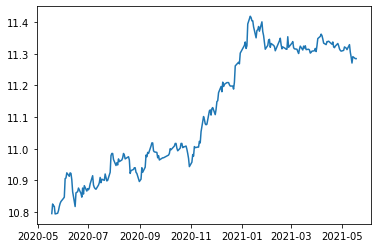

In [11]:
# 로그 변환 시도 
ts_log = np.log(ts)
plt.plot(ts_log)

# STEP 3 : 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

In [99]:
def plot_rolling_statistics(timeseries, window=5): #원래 12
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3
슝=3


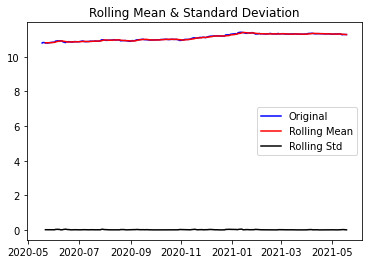

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


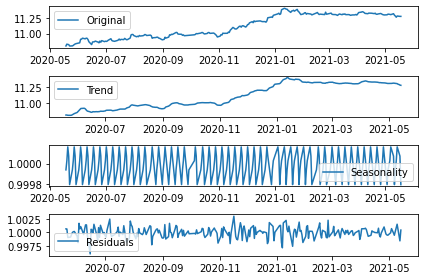

In [103]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=5) #원래 12

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 5)  # 원래 30

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [104]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -9.783378e+00
p-value                        6.641628e-17
#Lags Used                     6.000000e+00
Number of Observations Used    2.390000e+02
Critical Value (1%)           -3.458011e+00
Critical Value (5%)           -2.873710e+00
Critical Value (10%)          -2.573256e+00
dtype: float64


# STEP 4 : 학습, 테스트 데이터셋 생성
- 학습, 테스트 데이터셋 분리

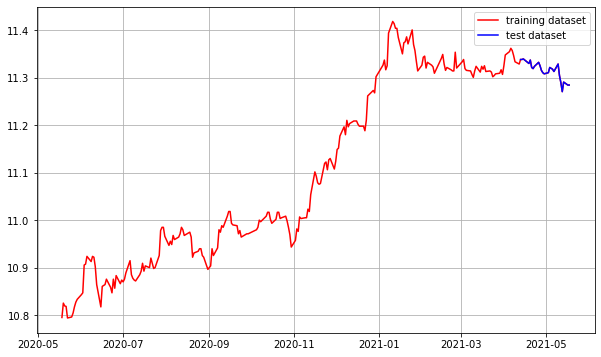

In [105]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()


# STEP 5 : 적정 ARIMA 모수 찾기
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


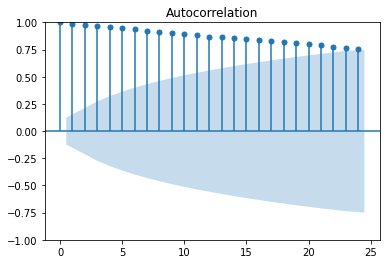

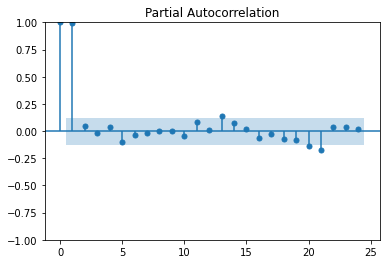

In [106]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


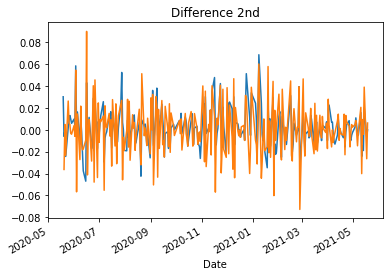

In [107]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:] # 원래 1
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:] # 원래 1
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# STEP 6 : ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)


In [161]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(10, 0, 0))   #원래 1,0,1
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                ARIMA(10, 0, 0)   Log Likelihood                 584.876
Date:                Thu, 10 Feb 2022   AIC                          -1145.752
Time:                        15:01:20   BIC                          -1104.759
Sample:                             0   HQIC                         -1129.207
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0700      0.124     89.167      0.000      10.827      11.313
ar.L1          1.0286      0.068     15.223      0.000       0.896       1.161
ar.L2         -0.0461      0.110     -0.420      0.6

/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


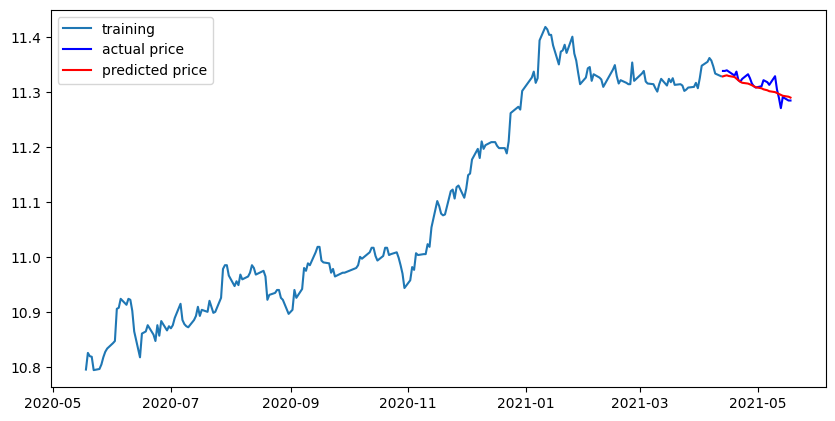

In [162]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [163]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  855751.5735638451
MAE:  716.0436666665768
RMSE:  925.068415612513
MAPE: 0.87%


# STEP 7 : 다른 주식 종목 예측해 보기
- 관심 종목을 골라 위 STEP 1~6의 과정을 반복해 보기

## 1. GOOG

In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/GOOG.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2017-02-13    819.239990
2017-02-14    820.450012
2017-02-15    818.979980
2017-02-16    824.159973
2017-02-17    828.070007
Name: Close, dtype: float64

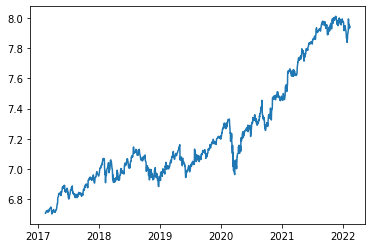

In [167]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

# 로그 변환 시도 
ts_log = np.log(ts)
plt.plot(ts_log)

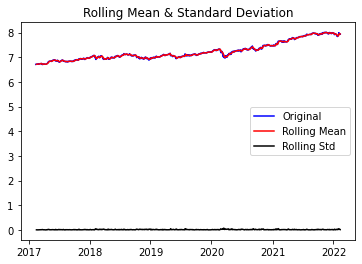

Results of Dickey-Fuller Test:
Test Statistic                    0.066947
p-value                           0.963731
#Lags Used                       22.000000
Number of Observations Used    1236.000000
Critical Value (1%)              -3.435652
Critical Value (5%)              -2.863881
Critical Value (10%)             -2.568016
dtype: float64


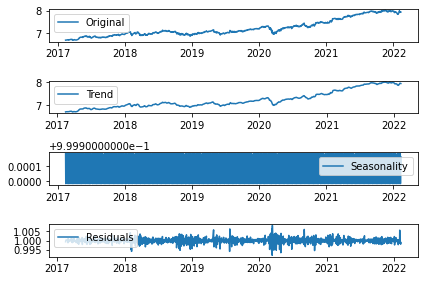

In [168]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=5) #원래 12

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 5)  # 원래 30

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [169]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.181886e+01
p-value                        8.508586e-22
#Lags Used                     2.300000e+01
Number of Observations Used    1.231000e+03
Critical Value (1%)           -3.435673e+00
Critical Value (5%)           -2.863891e+00
Critical Value (10%)          -2.568022e+00
dtype: float64


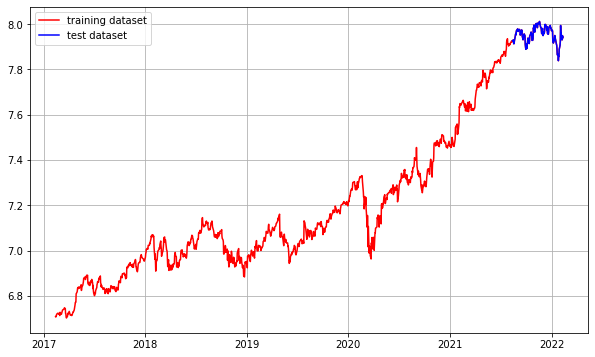

In [170]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()


/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


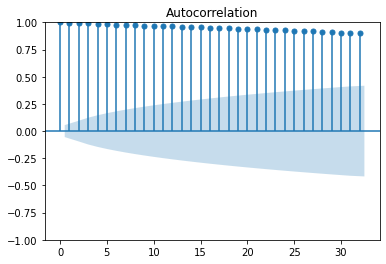

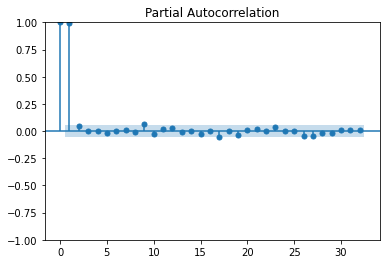

In [171]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

분석 결과 p=1로 지정하면 좋을 것 같다.

Results of Dickey-Fuller Test:
Test Statistic                -8.223102e+00
p-value                        6.351329e-13
#Lags Used                     2.100000e+01
Number of Observations Used    1.236000e+03
Critical Value (1%)           -3.435652e+00
Critical Value (5%)           -2.863881e+00
Critical Value (10%)          -2.568016e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.617699e+01
p-value                        4.305690e-29
#Lags Used                     1.600000e+01
Number of Observations Used    1.240000e+03
Critical Value (1%)           -3.435635e+00
Critical Value (5%)           -2.863874e+00
Critical Value (10%)          -2.568012e+00
dtype: float64


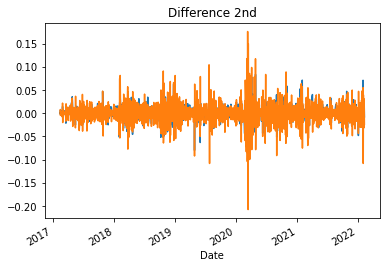

In [172]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:] # 원래 1
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:] # 원래 1
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [224]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 1, 0))   #원래 1,0,1
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1133
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2986.831
Date:                Thu, 10 Feb 2022   AIC                          -5969.663
Time:                        15:15:30   BIC                          -5959.599
Sample:                             0   HQIC                         -5965.861
                               - 1133                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1332      0.018     -7.418      0.000      -0.168      -0.098
sigma2         0.0003    6.8e-06     43.947      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.02   Jarque-

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


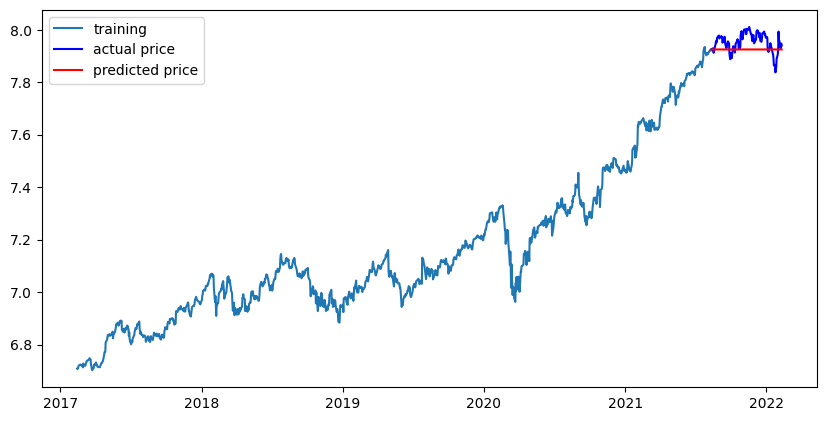

In [225]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [226]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  15898.8556143258
MAE:  106.54397396123716
RMSE:  126.09066426316343
MAPE: 3.70%


## 2. TSLA

p,d,q = 1,2,1 로 주었다

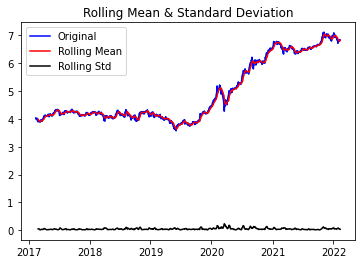

Results of Dickey-Fuller Test:
Test Statistic                    0.282325
p-value                           0.976519
#Lags Used                        0.000000
Number of Observations Used    1258.000000
Critical Value (1%)              -3.435559
Critical Value (5%)              -2.863840
Critical Value (10%)             -2.567995
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.191051e+01
p-value                        5.310284e-22
#Lags Used                     2.100000e+01
Number of Observations Used    1.227000e+03
Critical Value (1%)           -3.435691e+00
Critical Value (5%)           -2.863898e+00
Critical Value (10%)          -2.568026e+00
dtype: float64


/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


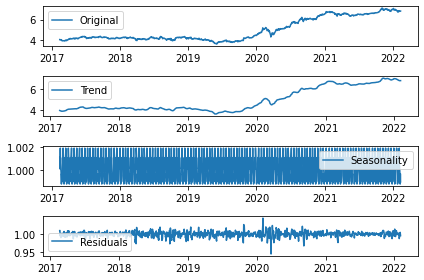

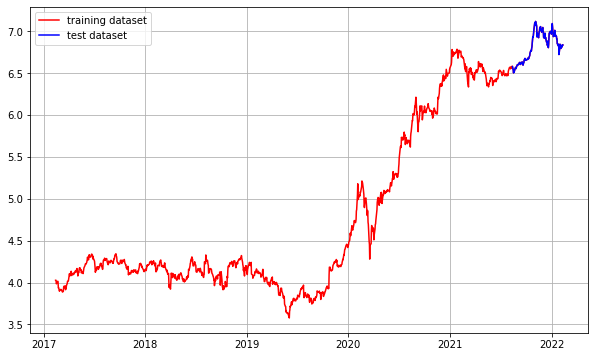

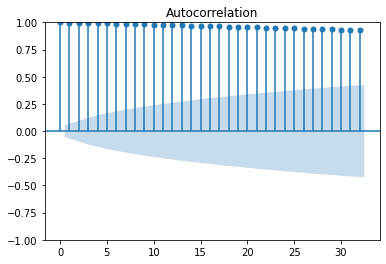

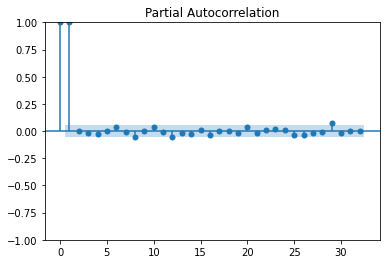

Results of Dickey-Fuller Test:
Test Statistic                  -36.038556
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1257.000000
Critical Value (1%)              -3.435563
Critical Value (5%)              -2.863842
Critical Value (10%)             -2.567996
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.239390e+01
p-value                        4.722091e-23
#Lags Used                     2.300000e+01
Number of Observations Used    1.233000e+03
Critical Value (1%)           -3.435665e+00
Critical Value (5%)           -2.863887e+00
Critical Value (10%)          -2.568020e+00
dtype: float64


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1133
Model:                 ARIMA(1, 2, 1)   Log Likelihood                2070.371
Date:                Thu, 10 Feb 2022   AIC                          -4134.741
Time:                        15:18:36   BIC                          -4119.649
Sample:                             0   HQIC                         -4129.040
                               - 1133                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0213      0.020     -1.044      0.297      -0.061       0.019
ma.L1         -0.9954      0.002   -400.405      0.000      -1.000      -0.990
sigma2         0.0015   3.37e-05     44.496      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


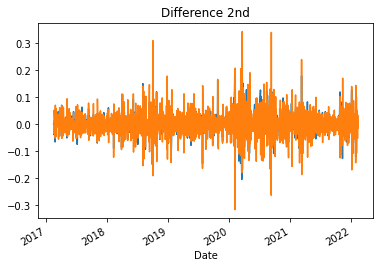

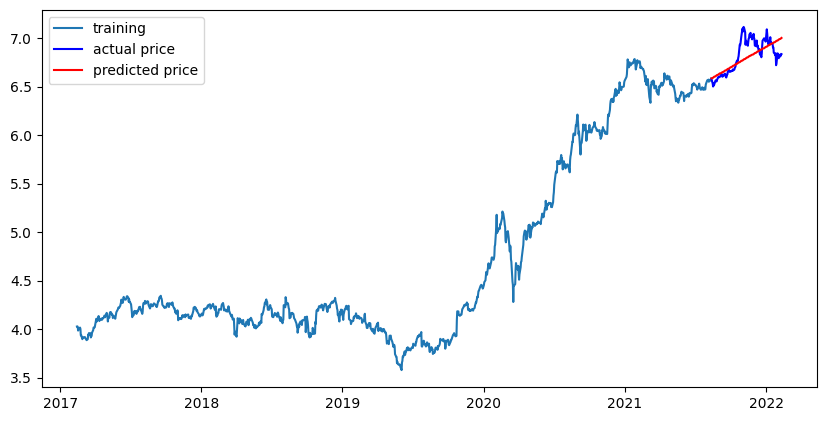

MSE:  16052.112296516678
MAE:  94.3066287645034
RMSE:  126.69693088830793
MAPE: 9.45%


In [232]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/TSLA.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

# 로그 변환 시도 
ts_log = np.log(ts)
plt.plot(ts_log)

# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=10) #원래 12

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 10)  # 원래 30

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:] # 원래 1
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:] # 원래 1
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)


from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 2, 1))   #원래 1,0,1
fitted_m = model.fit() 

print(fitted_m.summary())



# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))




## 3. MSFT
p,d,q 모두 1로 주었다!

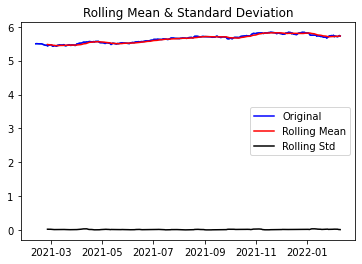

Results of Dickey-Fuller Test:
Test Statistic                  -1.181827
p-value                          0.681364
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.361965e+00
p-value                        9.448897e-11
#Lags Used                     1.200000e+01
Number of Observations Used    2.360000e+02
Critical Value (1%)           -3.458366e+00
Critical Value (5%)           -2.873866e+00
Critical Value (10%)          -2.573339e+00
dtype: float64


/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


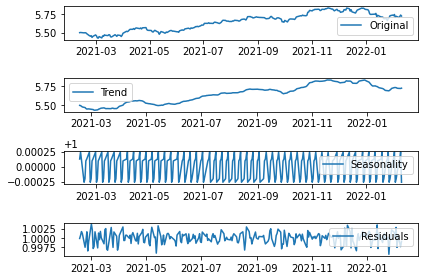

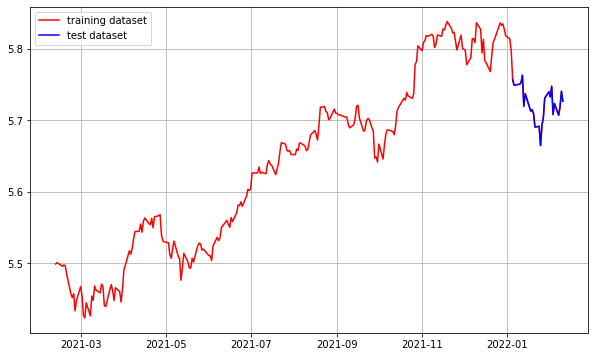

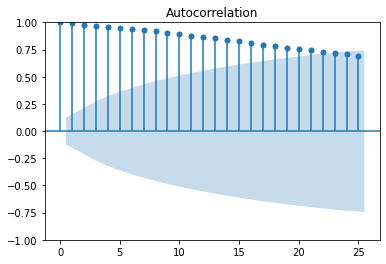

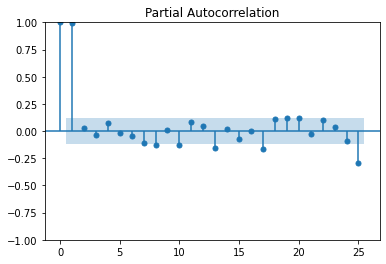

Results of Dickey-Fuller Test:
Test Statistic                -1.672770e+01
p-value                        1.391473e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.115781e+00
p-value                        3.834338e-10
#Lags Used                     1.400000e+01
Number of Observations Used    2.360000e+02
Critical Value (1%)           -3.458366e+00
Critical Value (5%)           -2.873866e+00
Critical Value (10%)          -2.573339e+00
dtype: float64
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 662.545
Date:                Thu, 10 Feb 2022   AIC            

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using

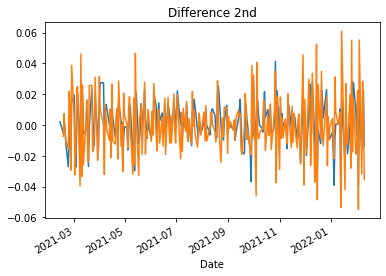

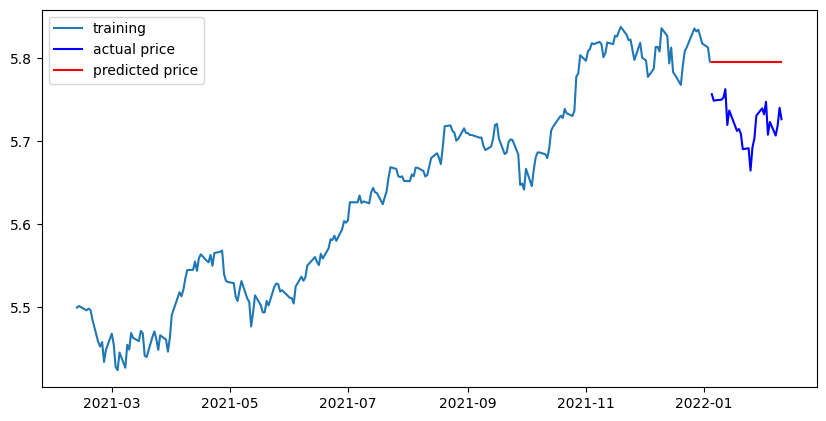

MSE:  568.3291523098533
MAE:  22.69694286481856
RMSE:  23.83965503755986
MAPE: 7.47%


In [238]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/MSFT.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

# 로그 변환 시도 
ts_log = np.log(ts)
plt.plot(ts_log)

# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=10) #원래 12

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 5)  # 원래 30

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:] # 원래 1
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:] # 원래 1
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)


from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 1, 1))   #원래 1,0,1
fitted_m = model.fit() 

print(fitted_m.summary())



# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))




# 회고

회고
1. 이번 프로젝트에서 어려웠던 점

통계학적 지식을 습득하는 부분이 어려웠다. 왜 로그함수를 사용하는지, 추세와 Time Series sequential data, 차분이 무엇인지 등

2. 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점.

코드도 코드지만, 통계적 개념이 부족했기 때문에 이를 보완하기 위해 많이 찾아 보았다. 윗부분에 개념 정리한 부분에서 확인할 수 있다.

3. 루브릭 평가 지표를 맞추기 위해 시도한 것들

p,d,q를 어떻게 확인하는지 파악하고 여러 시도를 해보며 정확도를 높였다.

4. 자기다짐

코인을 매매해주는 AI알고리즘을 짜서 돌리고 싶다. 코인 책도 빌려보고, 자동화를 위해선 어떤 것들을 구현하는지 찾아봐야겠다.

산업공학에 대해 관심이 생겨 조금씩 찾아봐야겠다

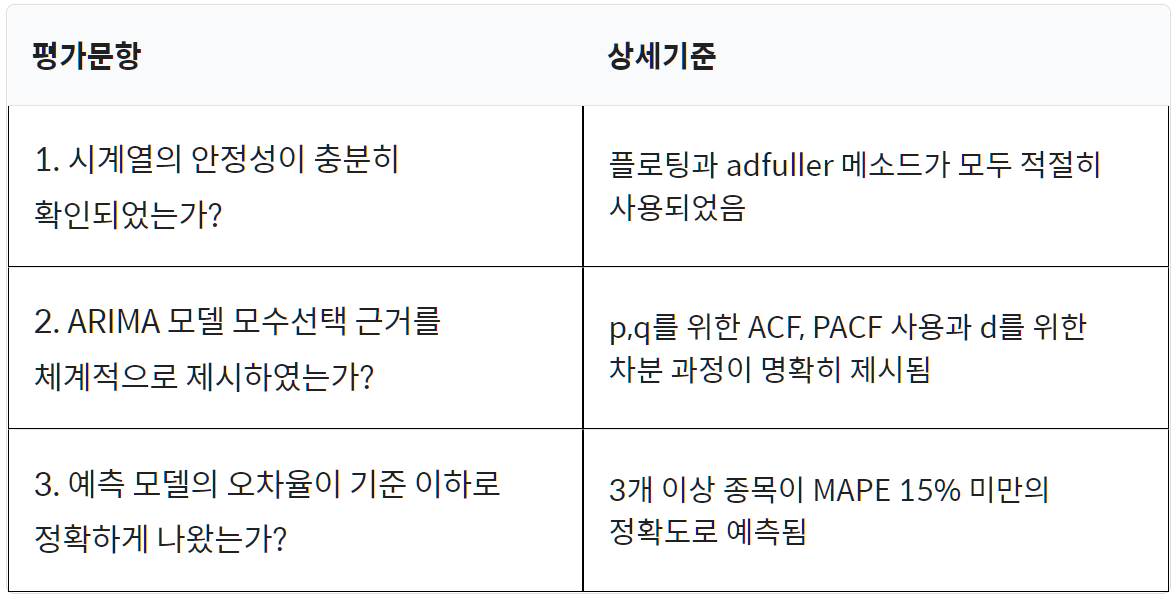